In [ ]:
class GaussianNoiseMutator():
    def __init__(self, **kwargs):
        self.lr = **kwargs['lr']
        
    def mutate_dna(self, dna):
        return dna + self.lr*torch.randn_like(dna)

class ConvMutator(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()

        self.seq = nn.Sequential(*[
            nn.Conv1d(2, 4, 5, padding=2),
            nn.ReLU(),
#             nn.MaxPool1d(2),
            nn.Conv1d(4, 4, 5, padding=2),
            nn.ReLU(),
#             nn.MaxPool1d(2),
            nn.Conv1d(4, 4, 5, padding=2),
            nn.ReLU(),
#             nn.MaxPool1d(3),
            nn.Conv1d(4, 1, 5, padding=2),
#             nn.MaxPool1d(1),
            nn.Sigmoid(),
        ])
        if kwargs['breeder_init_zeros']:
            for mod in self.modules():
                if type(mod) is nn.Conv1d:
                    mod.weight.data = torch.zeros_like(mod.weight)
                    mod.bias.data = torch.zeros_like(mod.bias)
        
    def forward(self, x):
        x = self.seq(x)[:, 0]
        return x
    
    def breed_dna(self, dna1, dna2):
        p = self(torch.stack([dna1, dna2], dim=-2)[None])[0]
        dna = dna1.clone()
        mask = torch.rand_like(p)<p
        dna[mask] = dna2[mask]
        
        return dna
    

In [1]:
%load_ext autoreload
%autoreload 2

In [258]:
%run imports.py

In [3]:
task = mnist.MNIST()
task.load_all_data(device)

In [4]:
# import tempfile
# tb_log_dir = tempfile.mkdtemp()
user = os.getlogin()
tb_log_dir = f'/tmp/tensorboard/{user}'

In [5]:
if os.path.exists(tb_log_dir):
    shutil.rmtree(tb_log_dir)

In [6]:
logger = tb.SummaryWriter(tb_log_dir, flush_secs=5)

In [303]:
torch.manual_seed(1)
np.random.seed(1)
geno_cfg = {
    'pheno_class': models_pheno.SmallNet,
    'decoder_class': models_decode.IdentityDecoder,
    'breeder_class': models_breed.ConvRSBProbBreeder,
    
    'dna_mutate_lr': 1e-2,
    'dna_mutate_prob': 0,
    
    'decode_mutate_lr': 1e-2,
    'decode_mutate_prob': 0,
    'decode_weight_init_zeros': True,
    
    'breed_mutate_lr': 1e-3,
    'breed_mutate_prob': 0,
    'breed_weight_init_for_first_parent': True,
    'breeder_init_zeros': True,
    
    'dna_len': 20,
    'dna_init_std': 1e-1,
}

evol_cfg = {
    'fitness_func': task.calc_pheo_fitness,
    'n_pop': 30,
    'n_gen': 300,
    
    'select_cfg': {
        'k_elite': 1,
        'do_crossover': True,
        'with_replacement': True,
        'k_tournament': 15,
    },
    'fit2prob_cfg': {
        'temperature': 1,
        'normalize': True,
    },
}
tag = 'temp'
log_cfg = {
    'logger': logger,
    'tag': tag,
    'save_n_gens': 30,
    'save_n_agents': 30,
}

# logger.add_text(tag, f'NE with config: {config}')

ne = neuroevolution.Neuroevolution(geno_cfg, evol_cfg, log_cfg, device=device, verbose=True)
ne.run_evolution(tqdm=tqdm)

# logger.add_hparams(config, {key: value[-1] for key, value in ne.fitdata.items()}, run_name=tag)
# logger.add_hparams(config, {'best_fitness': ne.best_fitness, 'fitness_v_gen_AUC': ne.fitness_v_gen_AUC}, run_name=tag)

Running Neuroevolution with 
Population:  30
Generations:  300
Pheno   # params: 00130
------------------
DNA     # params: 00130
Decoder # params: 00000
Breeder # params: 00233
Total   # params:   363


In [272]:
fitdata_gens = cmaes.run_cmaes(models_pheno.SmallNet, task.calc_pheo_fitness, 300, 30, device, tqdm)

(15_w,30)-aCMA-ES (mu_w=8.6,w_1=20%) in dimension 130 (seed=964664, Wed Jun 16 16:53:26 2021)


[]

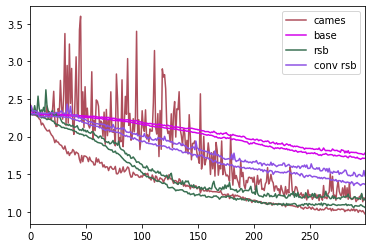

In [305]:
viz.plot_fits_vs_gens(util.arr_dict2dict_arr(fitdata_gens)['loss'], show_error=False, label='cames')
viz.plot_fits_vs_gens(ne_base.fitdata_gens_DA['loss'], show_error=False, label='base')
viz.plot_fits_vs_gens(ne_rsb.fitdata_gens_DA['loss'], show_error=False, label='rsb')
viz.plot_fits_vs_gens(ne_convrsb.fitdata_gens_DA['loss'], show_error=False, label='conv rsb')
plt.legend()
plt.plot()

In [244]:
ne1.pop_evol.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 59, 109, 158, 208, 257, 307, 356, 406, 455, 505, 554, 604, 653, 703, 752, 802, 851, 901, 950])

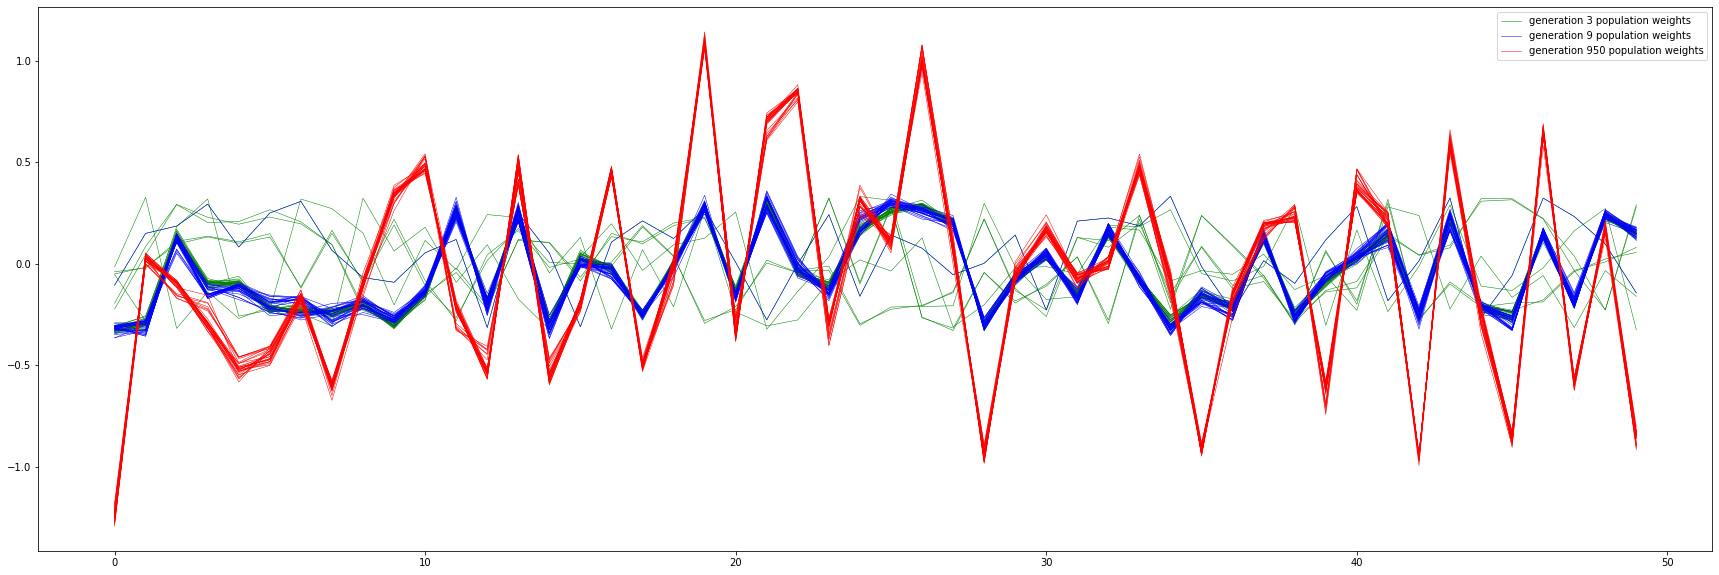

In [360]:
ne = ne_tourn
plt.figure(figsize=(30, 10))
data = torch.stack([g.geno_dna.dna for g in ne.pop_evol[3]]).detach().cpu().numpy()
plt.plot(data.T[:50], c='g', linewidth=.5)
plt.plot(data.T[:50, 0], c='g', linewidth=.5, label='generation 3 population weights');
data = torch.stack([g.geno_dna.dna for g in ne.pop_evol[9]]).detach().cpu().numpy()
plt.plot(data.T[:50], c='b', linewidth=.5)
plt.plot(data.T[:50, 0], c='b', linewidth=.5, label='generation 9 population weights');
data = torch.stack([g.geno_dna.dna for g in ne.pop_evol[950]]).detach().cpu().numpy()
plt.plot(data.T[:50], c='r', linewidth=.5)
plt.plot(data.T[:50, 0], c='r', linewidth=.5, label='generation 950 population weights');
plt.legend()
plt.show()

In [341]:
2000*2000

4000000

In [347]:
2*50*50+2*40*40

8200

In [353]:
layer = nn.MultiheadAttention(30, 1)
np.sum([p.numel() for p in layer.parameters()])

3720

In [211]:
cames_fitdata_gens = cmaes.run_cmaes(models_pheno.BigConvNet, task.calc_pheo_fitness, 1000, device, tqdm)

(50_w,100)-aCMA-ES (mu_w=27.0,w_1=8%) in dimension 2140 (seed=693354, Sun Jun 13 18:09:21 2021)


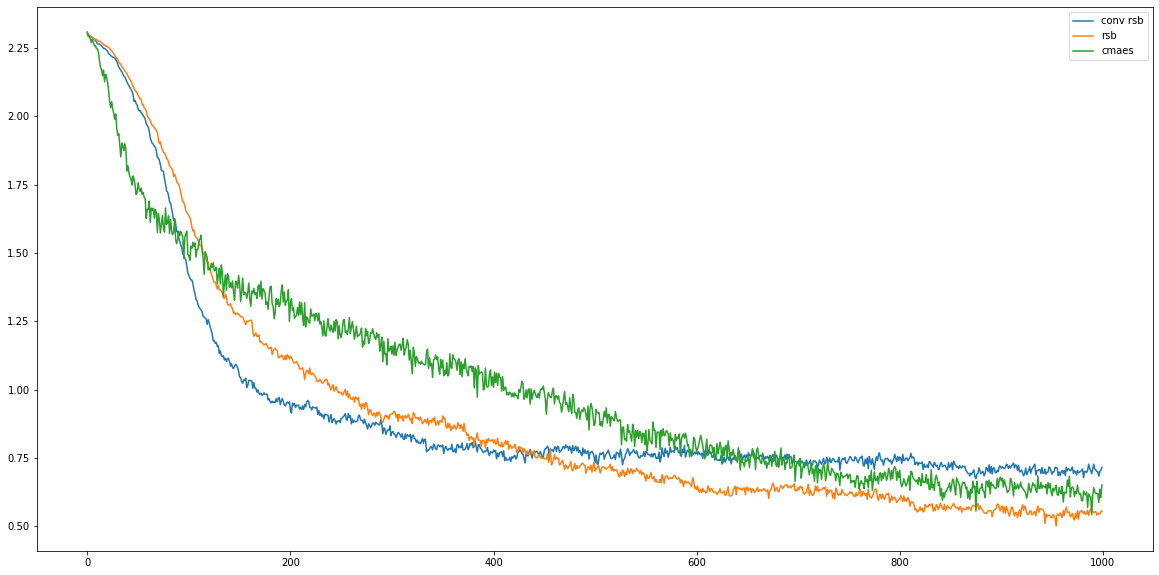

In [225]:
# from IPython.display import clear_output
#     clear_output(wait=True)
plt.figure(figsize=(20,10))
plt.plot(util.arr_dict2dict_arr(np.array(ne_conv_rsb.fitdata_gens))['loss'].min(axis=-1), label='conv rsb')
plt.plot(util.arr_dict2dict_arr(np.array(ne_rsb.fitdata_gens))['loss'].min(axis=-1), label='rsb')
plt.plot(util.arr_dict2dict_arr(cames_fitdata_gens)['loss'].min(axis=-1), label='cmaes')
plt.legend()
plt.show()

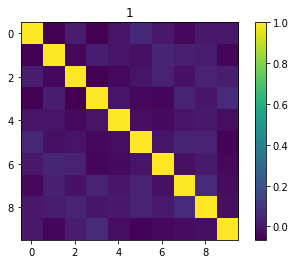

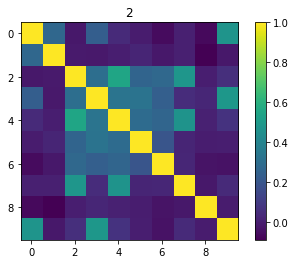

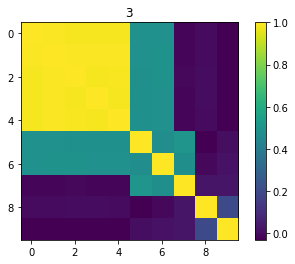

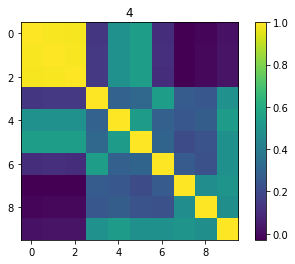

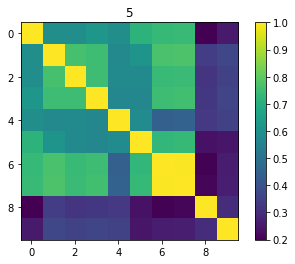

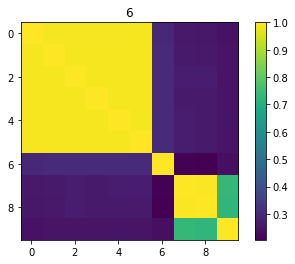

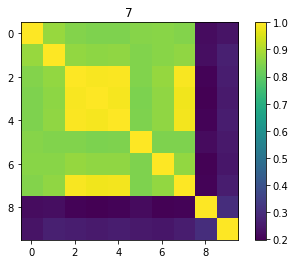

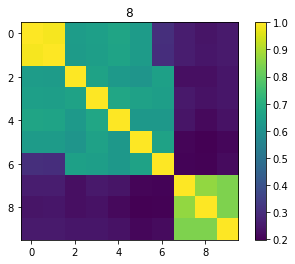

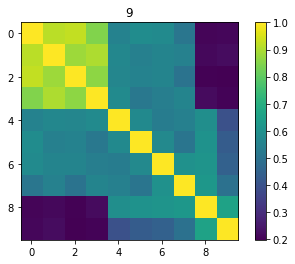

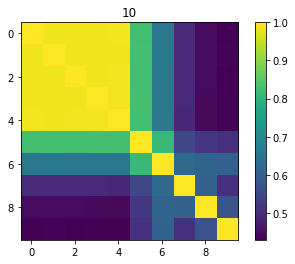

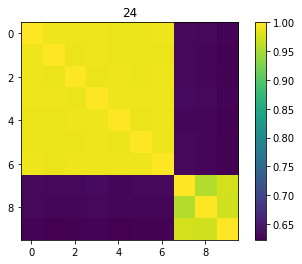

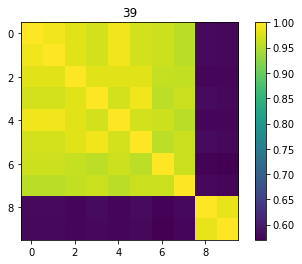

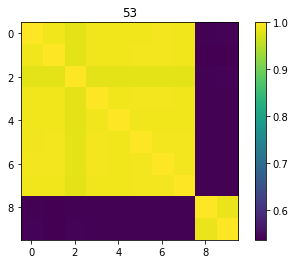

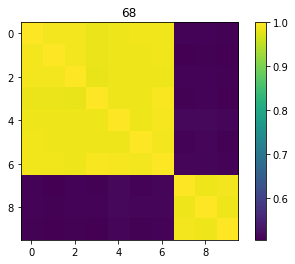

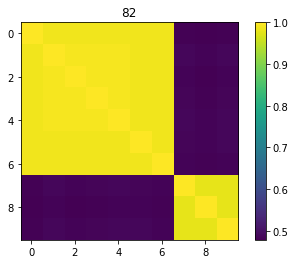

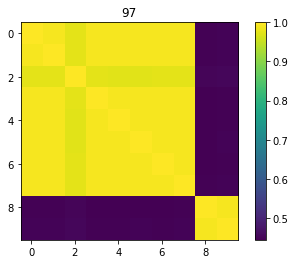

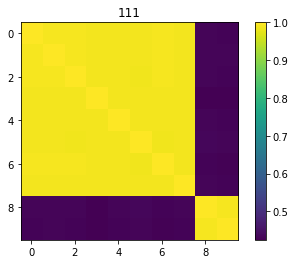

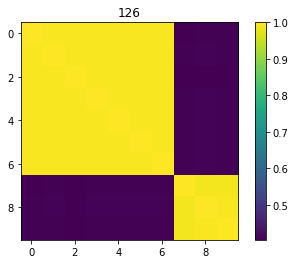

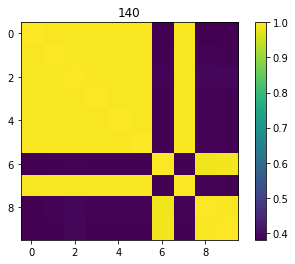

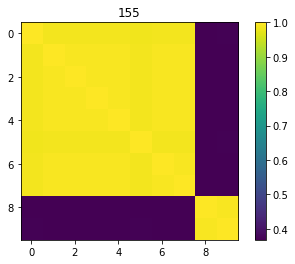

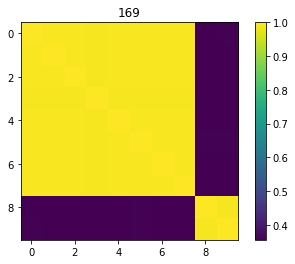

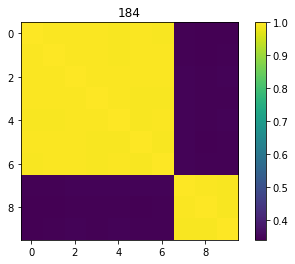

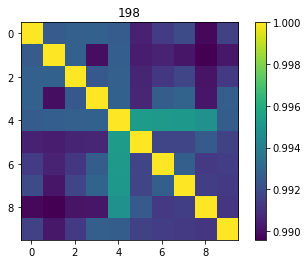

In [185]:
for gen_idx in ne.pop_evol.keys():
    data = torch.stack([g.geno_dna.dna for g in ne.pop_evol[gen_idx]])
    data = util.calc_pairwise_cossim(data).detach().cpu().numpy()
    plt.imshow(data);plt.colorbar()
    plt.title(gen_idx);plt.show()

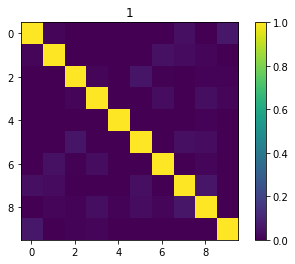

In [162]:
for gen_idx in ne.pop_evol.keys():
    data = torch.stack([g.geno_dna.dna for g in ne.pop_evol[gen_idx]])
    data = calc_pairwise_corr(data)
    plt.imshow(data.detach().cpu().numpy(), vmin=0, vmax=1); plt.colorbar()
    plt.title(gen_idx)
    plt.show()
    break

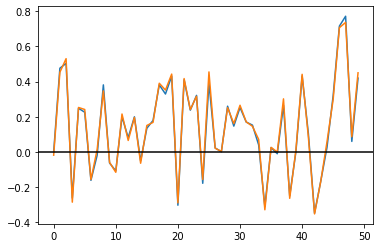

In [132]:
plt.plot(ne_conv_rsb.pop_evol[285][0].geno_dna.dna.detach().cpu().numpy()[:50])
plt.plot(ne_conv_rsb.pop_evol[285][1].geno_dna.dna.detach().cpu().numpy()[:50])
plt.axhline(c='k')

In [72]:
import cmaes
cmaes.run_cmaes(models_pheno.BigConvNet, task.calc_pheo_fitness, 50, device, tqdm)

(50_w,100)-aCMA-ES (mu_w=27.0,w_1=8%) in dimension 2140 (seed=745196, Sun Jun 13 15:32:18 2021)


array([[{'fitness': -2.300755739212036, 'loss': 2.300755739212036, 'accuracy': 14.879999999999999},
        {'fitness': -2.3733747005462646, 'loss': 2.3733747005462646, 'accuracy': 10.54},
        {'fitness': -2.351889133453369, 'loss': 2.351889133453369, 'accuracy': 9.4},
        ...,
        {'fitness': -2.4545676708221436, 'loss': 2.4545676708221436, 'accuracy': 12.06},
        {'fitness': -2.3605446815490723, 'loss': 2.3605446815490723, 'accuracy': 9.32},
        {'fitness': -2.4136621952056885, 'loss': 2.4136621952056885, 'accuracy': 10.059999999999999}],
       [{'fitness': -2.336690902709961, 'loss': 2.336690902709961, 'accuracy': 10.22},
        {'fitness': -2.3351197242736816, 'loss': 2.3351197242736816, 'accuracy': 11.24},
        {'fitness': -2.3412933349609375, 'loss': 2.3412933349609375, 'accuracy': 9.94},
        ...,
        {'fitness': -2.3325352668762207, 'loss': 2.3325352668762207, 'accuracy': 12.76},
        {'fitness': -2.3054134845733643, 'loss': 2.3054134845733643

In [23]:
import cma
model = models_pheno.BigConvNet
net = model().to(device)

def pheno_fitness(sol, net=net):
    sol = torch.tensor(sol, device=device).to(torch.float32)
    net = util.vec2model(sol, net).to(device)
    fit = task.calc_pheo_fitness(net, device=device)['loss']
    return fit

sol = util.model2vec(net).detach().cpu().numpy()

es = cma.CMAEvolutionStrategy(sol, 1e-1, {'popsize':100})
# es.optimize(pheno_fitness)
fits_gens = []
for _ in tqdm(range(300)):
    sols = es.ask()
    fits = [pheno_fitness(sol) for sol in sols]
    es.tell(sols, fits)
    fits_gens.append(fits)
    print(np.min(fits_gens))

(50_w,100)-aCMA-ES (mu_w=27.0,w_1=8%) in dimension 2140 (seed=696810, Sat Jun 12 18:19:41 2021)


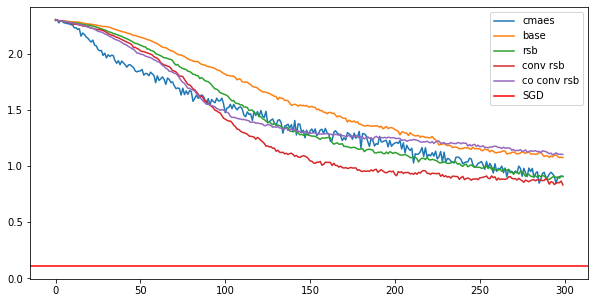

In [44]:
plt.figure(figsize=(10,5))
# plt.plot
plt.plot(fits_cmaes.min(axis=-1), label='cmaes')
plt.plot(util.arr_dict2dict_arr(np.array(ne_base.fitdata_gens))['loss'].min(axis=-1), label='base')
plt.plot(util.arr_dict2dict_arr(np.array(ne_rsb.fitdata_gens))['loss'].min(axis=-1), label='rsb')
plt.plot(util.arr_dict2dict_arr(np.array(ne_conv_rsb.fitdata_gens))['loss'].min(axis=-1), label='conv rsb')
plt.plot(util.arr_dict2dict_arr(np.array(co_ne_conv_rsb.fitdata_gens))['loss'].min(axis=-1), label='co conv rsb')
plt.axhline(torch.load('data/mnist_sgd_eval')[models_pheno.BigConvNet]['loss'], c='r', label='SGD')
plt.legend()

(-2.3, -0.9)

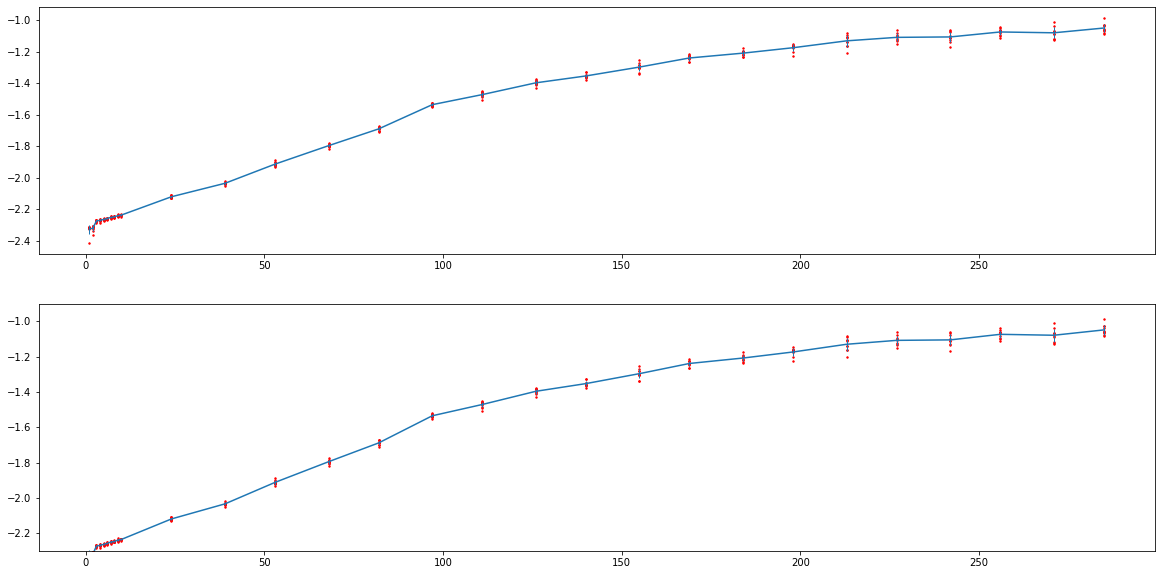

In [13]:
import viz
fitdata = viz.eval_evolution_with_good_geno(ne, 'good1', 'evol1', 'evol2', 'evol1', n_samp=10)
fitdata = util.arr_dict2dict_arr(np.array(fitdata).reshape(29, 10))['fitness']
# plt.plot(list(ne.pop_evol.keys()), fitdata.max(axis=-1))
viz.viz_evolution_with_good_geno(np.array(list(ne.pop_evol.keys())), fitdata)
plt.ylim(-2.3, -.9)

In [22]:
torch.manual_seed(1)
np.random.seed(1)
geno_config = {
    'pheno_class': models_pheno.BigConvNet,
    'decoder_class': models_decode.IdentityDecoder,
    'breeder_class': models_breed.ConvRSBProbBreeder,
    
    'dna_mutate_lr': 1e-2,
    'dna_mutate_prob': 0,
    
    'decode_mutate_lr': 1e-2,
    'decode_mutate_prob': 0,
    'decode_weight_init_zeros': False,
    
    'breed_mutate_lr': 1e-3,
    'breed_mutate_prob': 0,
    'breed_weight_init_for_first_parent': True,
    'breeder_init_zeros': True,
    
    'dna_len': 50,
    'dna_init_std': 1e-1,
}

evol_config = {
    'fitness_func': task.calc_pheo_fitness,
    'n_pop': 100,
    'n_pop_decoder': 10,
    'n_pop_breeder': 10,
    
    'n_gen': 300,
    'n_sample_eval_dna': 3,
    'n_sample_eval_decoder': 3,
    'n_sample_eval_breeder': 3,
    
    'select_cfg': {
        'k_elite': 5,
        'do_crossover': True,
        'with_replacement': True,
    },
    'select_cfg_decoder': {
        'k_elite': 5,
        'do_crossover': False,
        'with_replacement': True,
    },
    'select_cfg_breeder': {
        'k_elite': 5,
        'do_crossover': False,
        'with_replacement': True,
    },
    'fit2prob_cfg': {
        'inv_temp': 5,
        'normalize': True,
    },
}
tag = 'learned_rsb_init0'
log_config = {
    'logger': logger,
    'tag': tag,
    'save_n_gens': 100,
    'save_top_k_agents': 20,
}

# logger.add_text(tag, f'NE with config: {config}')

co_ne = co_neuroevolution.Neuroevolution(geno_config, evol_config, device=device, verbose=True, logger=logger, tag=tag)
co_ne.run_evolution(tqdm=tqdm)

# logger.add_hparams(config, {key: value[-1] for key, value in ne.fitdata.items()}, run_name=tag)
# logger.add_hparams(config, {'best_fitness': ne.best_fitness, 'fitness_v_gen_AUC': ne.fitness_v_gen_AUC}, run_name=tag)

Running Neuroevolution with 
Population:  100
Generations:  300
Pheno   # params: 02140
------------------
DNA     # params: 02140
Decoder # params: 00000
Breeder # params: 00233
Total   # params:  2373


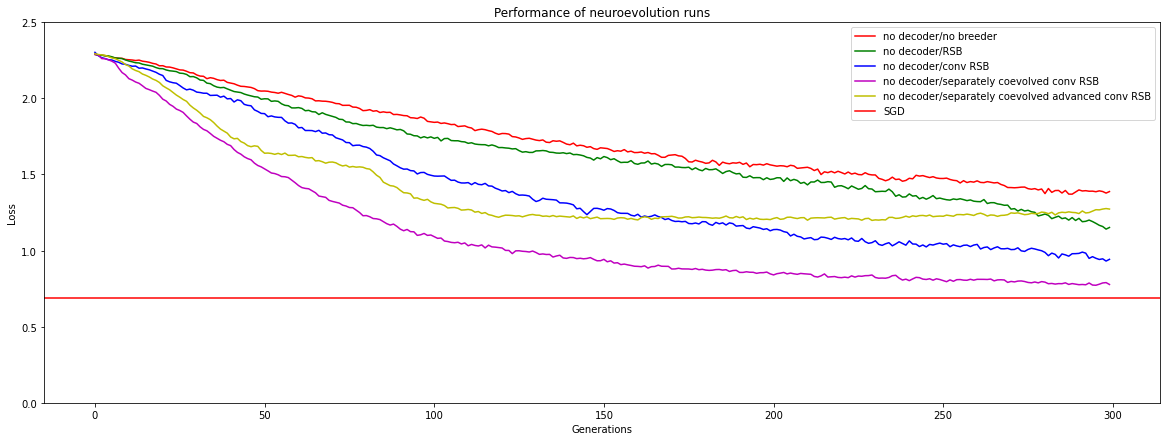

In [182]:
plt.figure(figsize=(20, 7))
ind = [0]
plt.plot(np.sort(util.arr_dict2dict_arr(np.array(ne_base.fitdata_gens))['loss'], axis=-1)[:, ind], c='r', label='no decoder/no breeder')
plt.plot(np.sort(util.arr_dict2dict_arr(np.array(ne_rsb.fitdata_gens))['loss'], axis=-1)[:, ind], c='g', label='no decoder/RSB')
plt.plot(np.sort(util.arr_dict2dict_arr(np.array(ne_lrsb.fitdata_gens))['loss'], axis=-1)[:, ind], c='b', label='no decoder/conv RSB')
plt.plot(np.sort(util.arr_dict2dict_arr(np.array(co_ne_lrsb.fitdata_gens))['loss'], axis=-1)[:, ind], c='m', label='no decoder/separately coevolved conv RSB')
plt.plot(np.sort(util.arr_dict2dict_arr(np.array(co_ne_adv_lrsb.fitdata_gens))['loss'], axis=-1)[:, ind], c='y', label='no decoder/separately coevolved advanced conv RSB')
plt.axhline(torch.load('data/mnist_sgd_eval')[models_pheno.SmallNet]['loss'], c='r', label='SGD')
plt.title('Performance of neuroevolution runs')
plt.xlabel('Generations'); plt.ylabel('Loss')
plt.ylim(0, 2.5); plt.legend()
plt.show()

In [204]:
task.perform_stats(net, device=device)

Average Loss: 2.388, Accuracy: 8.920%


{'loss': 2.3875574111938476, 'accuracy': 8.92}

(0.0, 2.5)

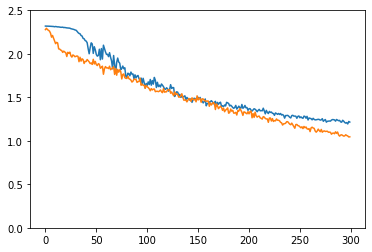

In [308]:
import viz
viz.plot_generation_fitnesses(y, show_dist=False)
plt.ylim(0, 2.5)

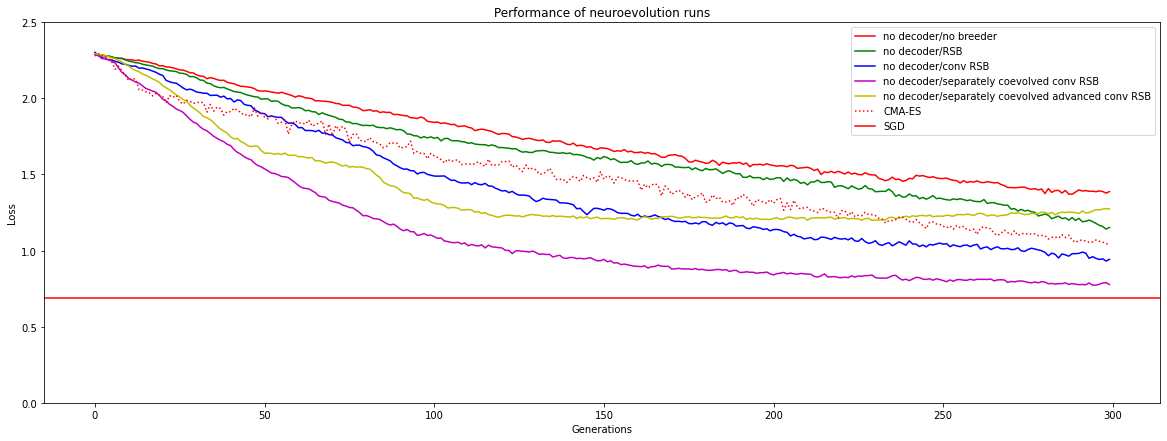

In [322]:
plt.figure(figsize=(20, 7))
ind = [0]
plt.plot(np.sort(util.arr_dict2dict_arr(np.array(ne_base.fitdata_gens))['loss'], axis=-1)[:, ind], c='r', label='no decoder/no breeder')
plt.plot(np.sort(util.arr_dict2dict_arr(np.array(ne_rsb.fitdata_gens))['loss'], axis=-1)[:, ind], c='g', label='no decoder/RSB')
plt.plot(np.sort(util.arr_dict2dict_arr(np.array(ne_lrsb.fitdata_gens))['loss'], axis=-1)[:, ind], c='b', label='no decoder/conv RSB')
plt.plot(np.sort(util.arr_dict2dict_arr(np.array(co_ne_lrsb.fitdata_gens))['loss'], axis=-1)[:, ind], c='m', label='no decoder/separately coevolved conv RSB')
plt.plot(np.sort(util.arr_dict2dict_arr(np.array(co_ne_adv_lrsb.fitdata_gens))['loss'], axis=-1)[:, ind], c='y', label='no decoder/separately coevolved advanced conv RSB')
# viz.plot_generation_fitnesses(y2, show_dist=False, c='r+', label='CMA-ES')
plt.plot(y2.min(axis=-1), 'r:', label='CMA-ES')
plt.axhline(torch.load('data/mnist_sgd_eval')[models_pheno.SmallNet]['loss'], c='r', label='SGD')
plt.title('Performance of neuroevolution runs')
plt.xlabel('Generations'); plt.ylabel('Loss')
plt.ylim(0, 2.5); plt.legend()
plt.show()

In [38]:
a = np.min(util.arr_dict2dict_arr(ne1.calc_fitdata(ne1.pop))['loss'])

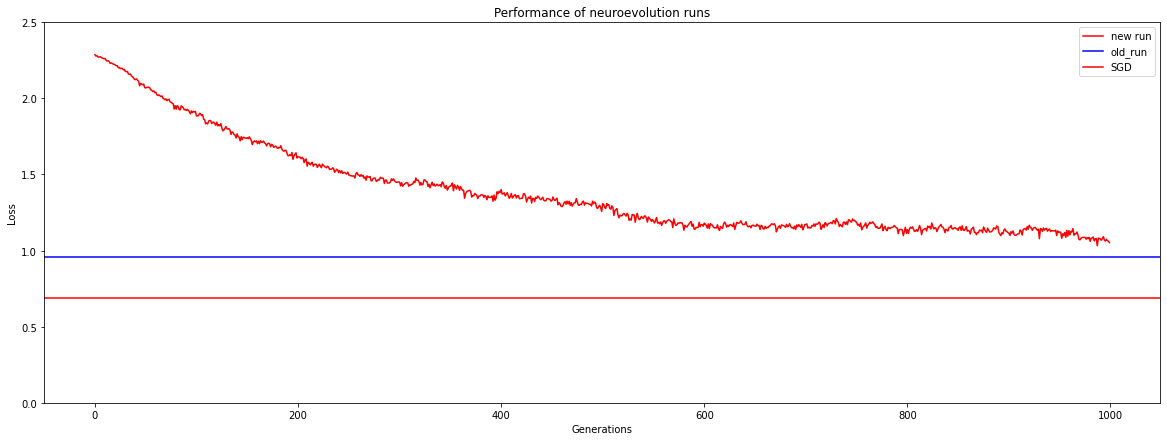

In [39]:
plt.figure(figsize=(20, 7))
ind = [0]
plt.plot(np.sort(util.arr_dict2dict_arr(np.array(ne.fitdata_gens))['loss'], axis=-1)[:, ind], c='r', label='new run')
# plt.plot(np.sort(util.arr_dict2dict_arr(np.array(ne1.fitdata_gens))['loss'], axis=-1)[:, ind], c='b', label='old run')
# plt.plot(np.sort(util.arr_dict2dict_arr(np.array(ne_lrsb_init0.fitdata_gens))['loss'], axis=-1)[:, ind], c='g', label='learned conv rsb breeder init 0')
plt.axhline(a, c='b', label='old_run')
plt.axhline(torch.load('data/mnist_sgd_eval')[models_pheno.SmallNet]['loss'], c='r', label='SGD')
plt.title('Performance of neuroevolution runs')
plt.xlabel('Generations'); plt.ylabel('Loss')
plt.ylim(0, 2.5); plt.legend()
plt.show()

In [10]:
torch.load('data/mnist_sgd_eval')

{models_pheno.SmallNet: {'fitness': -0.6912355422973633,
  'loss': 0.6912355422973633,
  'accuracy': 78.32249999999999},
 models_pheno.ConvNet: {'fitness': -0.28138837218284607,
  'loss': 0.28138837218284607,
  'accuracy': 91.6425},
 models_pheno.BigConvNet: {'fitness': -0.10598196089267731,
  'loss': 0.10598196089267731,
  'accuracy': 96.65}}

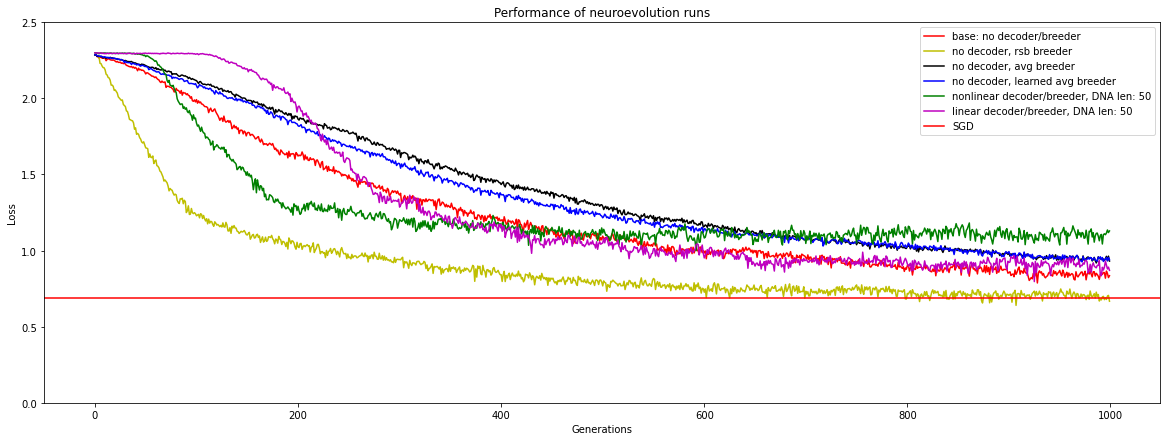

In [95]:
plt.figure(figsize=(20, 7))
x = np.arange(1000)
# plt.plot(np.sort(util.arr_dict2dict_arr(np.array(ne.fitdata_gens))['fitness'], axis=-1)[:, -1], label='hardcoded breeder')
# y = np.sort(util.arr_dict2dict_arr(np.array(ne_base.fitdata_gens))['loss'], axis=-1)[:, [0, -1]]
# plt.errorbar(x=x, y=y.mean(axis=-1), yerr=(y[:, 1]-y[:, 0])/2., c='b', elinewidth=0.5, label='base_ne')
# y = np.sort(util.arr_dict2dict_arr(np.array(ne_rsb.fitdata_gens))['loss'], axis=-1)[:, [0, -1]]
# plt.errorbar(x=x, y=y.mean(axis=-1), yerr=(y[:, 1]-y[:, 0])/2., c='g', elinewidth=0.5, label='random swap breeder')
# y = np.sort(util.arr_dict2dict_arr(np.array(ne_avg.fitdata_gens))['loss'], axis=-1)[:, [0, -1]]
# plt.errorbar(x=x, y=y.mean(axis=-1), yerr=(y[:, 1]-y[:, 0])/2., c='k', elinewidth=0.5, label='average breeder')
# y = np.sort(util.arr_dict2dict_arr(np.array(ne_nonlin.fitdata_gens))['loss'], axis=-1)[:, [0, -1]]
# plt.errorbar(x=x, y=y.mean(axis=-1), yerr=(y[:, 1]-y[:, 0])/2., c='y', elinewidth=0.5, label='nonlinear')

ind = [0]

plt.plot(np.sort(util.arr_dict2dict_arr(np.array(ne_base.fitdata_gens))['loss'], axis=-1)[:, ind], c='r', label='base: no decoder/breeder')
plt.plot(np.sort(util.arr_dict2dict_arr(np.array(ne_rsb.fitdata_gens))['loss'], axis=-1)[:, ind], c='y', label='no decoder, rsb breeder')
plt.plot(np.sort(util.arr_dict2dict_arr(np.array(ne_avg.fitdata_gens))['loss'], axis=-1)[:, ind], c='k', label='no decoder, avg breeder')
plt.plot(np.sort(util.arr_dict2dict_arr(np.array(ne_lavg.fitdata_gens))['loss'], axis=-1)[:, ind], c='b', label='no decoder, learned avg breeder')
plt.plot(np.sort(util.arr_dict2dict_arr(np.array(ne_nonlin.fitdata_gens))['loss'], axis=-1)[:, ind], c='g', label='nonlinear decoder/breeder, DNA len: 50')
plt.plot(np.sort(util.arr_dict2dict_arr(np.array(ne_lin.fitdata_gens))['loss'], axis=-1)[:, ind], c='m', label='linear decoder/breeder, DNA len: 50')
plt.axhline(torch.load('data/mnist_sgd_eval')[models_pheno.SmallNet]['loss'], c='r', label='SGD')
plt.title('Performance of neuroevolution runs')
plt.xlabel('Generations'); plt.ylabel('Loss')
plt.ylim(0, 2.5); plt.legend()
plt.show()

In [107]:
geno = ne_rsb.pop[np.argmax(util.arr_dict2dict_arr(ne_rsb.fitdata)['fitness'])]
pheno = geno.load_pheno(models_decode.IdentityDecoder(), models_pheno.SmallNet().to(device))
task.perform_stats(pheno, device=device)
task.calc_pheo_fitness(pheno, device=device)

Average Loss: 0.733, Accuracy: 76.700%


{'fitness': -0.7590956091880798, 'loss': 0.7590956091880798, 'accuracy': 76.35}

In [61]:
import population

In [83]:
pheno = models_pheno.ConvNet().to(device)
decoder = models_decode.IdentityDecoder()

fits = np.zeros((2, 2, 1000))
for nei, ne in enumerate([ne1, ne2]):
    for bi, breeder in enumerate([models_breed.AverageBreeder(), models_breed.RandomSwapBreeder()]):
        prob = population.fit2prob_sm(ne.fitdata['fitness'], fit2prob_sm_iT=1., fit2prob_sm_normalize=False)
        for i in tqdm(range(1000)):
            geno1, geno2 = np.random.choice(ne.pop, size=(2), p=prob)
            dna = breeder.breed_dna(geno1.dna, geno2.dna)
            geno = neuroevolution.CombinedGenotype(dna, geno1.decoder_dna, geno1.breeder_dna)
            pheno = geno.to_pheno(decoder, pheno)
            fits[nei, bi, i] = task.calc_pheo_fitness(pheno, device=device)['fitness']


(-1.3, -0.7)

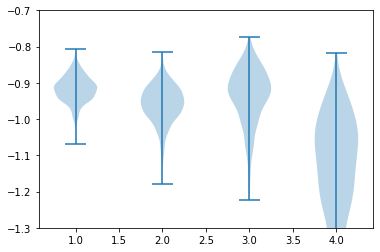

In [84]:
plt.violinplot(fits.reshape(4, 1000).T);
plt.ylim(-1.3, -.7)

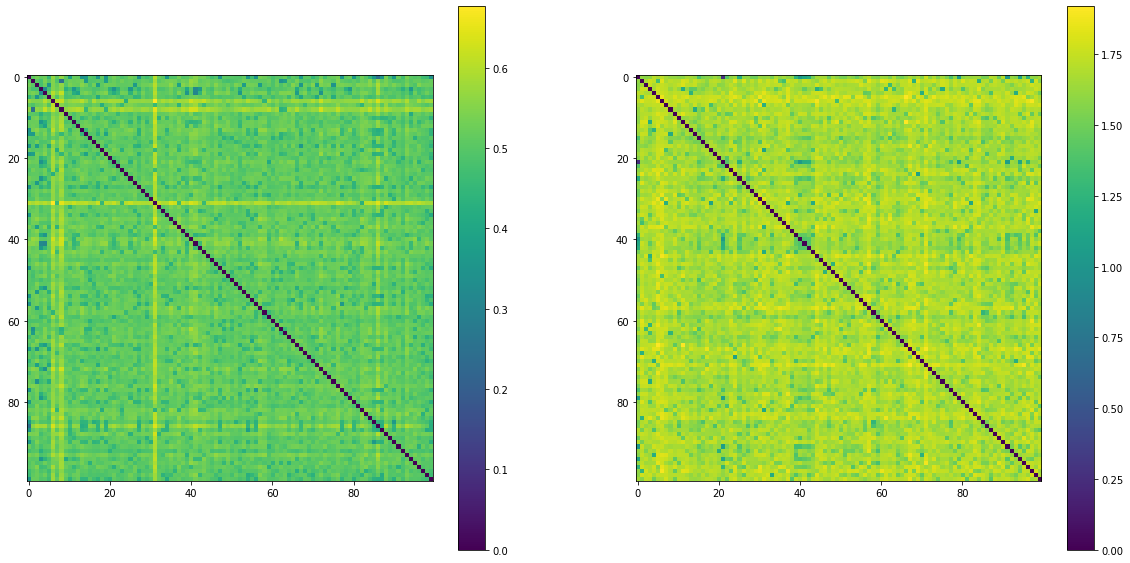

In [82]:
plt.figure(figsize=(20,10))
for nei, ne in enumerate([ne1, ne2]):
    plt.subplot(1,2,nei+1)
    a = torch.stack([geno.dna for geno in ne.pop]).cpu()
    plt.imshow((a[:, None] - a[None, :]).norm(dim=-1).numpy())
    plt.colorbar()


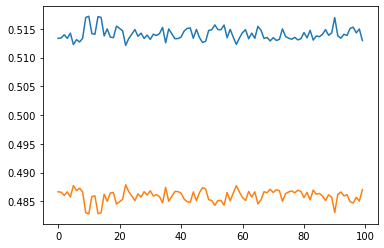

In [40]:
plt.plot(np.stack([geno.breeder_dna.cpu().softmax(dim=-1).numpy() for geno in ne.pop]))
# plt.scatter(np.ones(2), ne.pop[0].breeder_dna.cpu().softmax(dim=-1).numpy())

In [330]:
class TestGA(ga.SimpleGA):
    def __init__(self):
        fit2prob_cfg= {
            'temperature': 1,
            'normalize': True,
        }
        select_cfg = {
            'k_elite': 3,
            'do_crossover': True,
            'with_replacement': True,
        }    
        super().__init__(self.calc_ipop, self.calc_clone, self.calc_mutate, 
                         self.calc_crossover, 
                         fit2prob_cfg=fit2prob_cfg,
                         select_cfg=select_cfg)
        self.pheno = models_pheno.SmallNet().to(device)
        self.device = device
    
        
    def calc_ipop(self):
        return np.array([genotype.GenotypeContinuousMaskedDNA.generate_random(pheno_class=models_pheno.SmallNet, 
                                                                              device=self.device)
                         for _ in range(30)])
        
    def calc_clone(self, pop):
        return np.array([geno.clone() for geno in pop])

    def calc_mutate(self, pop):
        return np.array([geno.mutate() for geno in pop])
    
    def calc_crossover(self, pop1, pop2):
        return np.array([geno1.crossover(geno2, None, None) for geno1, geno2 in zip(pop1, pop2)])
    
    def calc_fitdata(self, pop):
        fitdata = []
        for geno in pop:
            pheno = geno.load_pheno(self.pheno)
            fitdata.append(task.calc_pheo_fitness(pheno, device=self.device))
        return np.array(fitdata)
    
        

ne1 = TestGA()
ne1.run_evolution(300, ne.calc_fitdata, tqdm)